Okay first thing's first, let's get the prerequisites installed. Aerosandbox will provide the simulation environment, and baseline will include gym and the related requirements for training a model to optimize within that simulation.

🚨 Using Python 3.9.6 (3.10.x has compatability issues with AeroSandbox)

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install 'aerosandbox[full]'
!{sys.executable} -m pip install 'gym[all]'

Alright let's set up the custom environment

First let's instantiate a plane with basic geometry:

In [2]:
import aerosandbox as asb
import aerosandbox.numpy as np

# Here, all distances are in meters and all angles are in degrees.
airplane = asb.Airplane(
    name="Example Airplane",
    xyz_ref=[0.5, 0, 0],  # Reference for moments
    s_ref=9,  # Reference area
    c_ref=0.9,  # Reference chord
    b_ref=10,  # Reference span
    wings=[
        asb.Wing(
            name="Wing",
            symmetric=True,  # Should this wing be mirrored across the XZ plane?
            xsecs=[  # The wing's cross ("X") sections, or "XSecs"
                asb.WingXSec(  # Root
                    xyz_le=[0, 0, .3],  # Coordinates of the XSec's leading edge
                    chord=1,
                    twist=1,  # in degrees
                    airfoil=asb.Airfoil("sd7032"),
                    control_surface_is_symmetric=False,  # Aileron
                    control_surface_deflection=45,  # in degrees
                    # (ctrl. surfs. are applied between this XSec and the next one.)
                ),
                asb.WingXSec(  # Tip
                    xyz_le=[0.2, 5, .3],
                    chord=0.6,
                    twist=-1,
                    airfoil=asb.Airfoil("sd7037"),
                )
            ]
        ),
        asb.Wing(
            name="H-stab",
            symmetric=True,
            xsecs=[
                asb.WingXSec(
                    xyz_le=[0, 0, 0],
                    chord=0.7,
                    airfoil=asb.Airfoil("ht08")
                ),
                asb.WingXSec(
                    xyz_le=[0.14, 1.25, 0],
                    chord=0.42,
                    airfoil=asb.Airfoil("ht08")
                ),
            ]
        ).translate([4, 0, 0]), # Used to translate all cross sections of the wing.
        asb.Wing(
            name="V-stab",
            xsecs=[
                asb.WingXSec(
                    xyz_le=[0, 0, 0],
                    chord=0.7,
                    airfoil=asb.Airfoil("ht08"),
                    control_surfaces=[
                        asb.ControlSurface(
                            hinge_point=0.2,
                            trailing_edge=True,
                            deflection=45
                        )
                    ]
                ),
                asb.WingXSec(
                    xyz_le=[0.14, 0, 1],
                    chord=0.42,
                    airfoil=asb.Airfoil("ht08")
                )
            ]
        ).translate([4, 0, 0]), # Used to translate all cross sections of the wing.
    ],
    fuselages=[
        asb.Fuselage(
            name="Fuselage",
            xsecs=[
                asb.FuselageXSec(
                    xyz_c=[xi * 5 - 0.5, 0, 0],
                    radius=asb.Airfoil("naca0024").local_thickness(x_over_c=xi)
                )
                for xi in np.cosspace(0, 1, 30)
            ]
        )
    ]
)

 F_g : [-1.65343852e+02 -6.04295498e-02  2.46905957e+03]
 F_b : (165.34385173680505, -0.060429549831588054, -2469.0595728936323)
 F_w : (-50.478052501487326, -0.060429549831588054, -2474.074721996186)
 M_g : [ 4.43009161e-03 -9.81589899e+01 -1.79315863e-01]
 M_b : (-0.004430091608225355, -98.15898991787101, 0.1793158626141135)
 M_w : (0.011215173420395259, -98.15898991787101, 0.17901961954448276)
   L : 2474.074721996186
   D : 50.478052501487326
   Y : -0.060429549831588054
 l_b : -0.004430091608225355
 m_b : -98.15898991787101
 n_b : 0.1793158626141135
  CL : 0.71809928034427
  CD : 0.014651236218626304
  CY : -1.753965466757575e-05
  Cl : -1.2858324639277897e-07
  Cm : -0.03165623423337436
  Cn : 5.204636333441565e-06


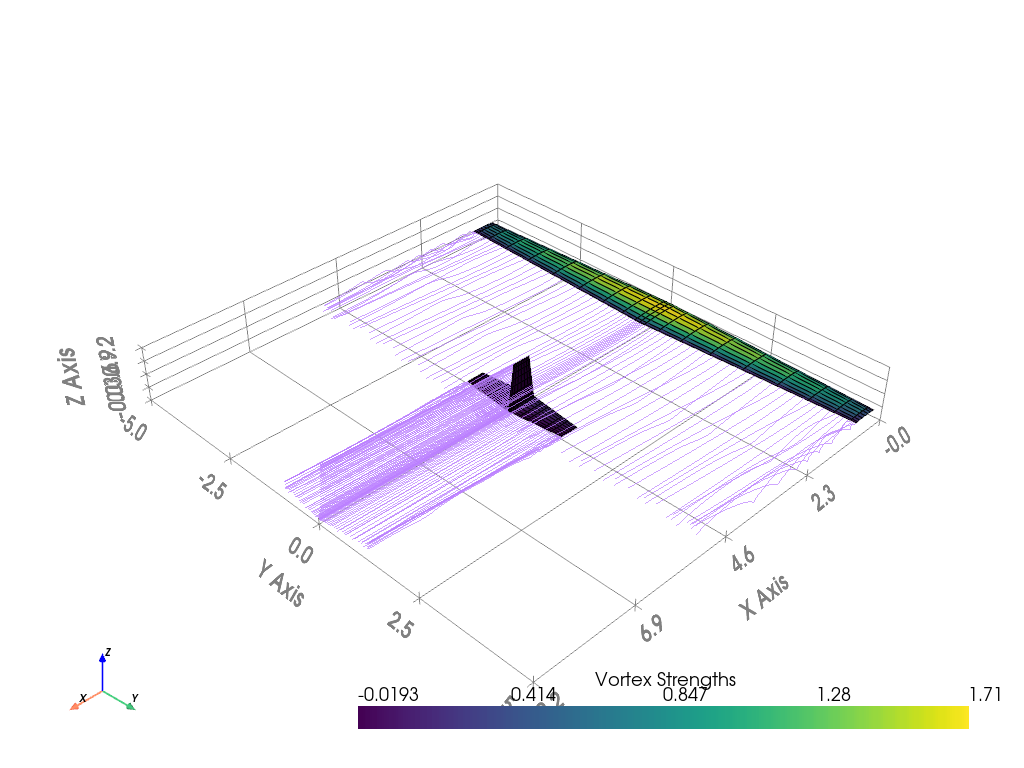

In [4]:
vlm = asb.VortexLatticeMethod(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=25,  # m/s
        alpha=5,  # degree
    )
)
aero = vlm.run()  # Returns a dictionary
for k, v in aero.items():
    print(f"{k.rjust(4)} : {v}")
vlm.draw(show_kwargs=dict(jupyter_backend="static"))

In [2]:
from gym import spaces

	
class AeroEnv(gym.Env):
	"""Custom Environment that follows gym interface"""

	def __init__(self):
		super(AeroEnv, self).__init__()
		# Define action and observation space
		# They must be gym.spaces objects
		# Example when using discrete actions:
		self.action_space = spaces.Box(low=0, high=1,
											shape=(
												3, #dX,dY,dZ, dScale
												12, # 12 cross sections
												), dtype=np.float64)
		
		# Example for using image as input (channel-first; channel-last also works):
		self.observation_space = spaces.Box(low=0, high=255,
											shape=(N_CHANNELS, HEIGHT, WIDTH), dtype=np.uint8)

	def step(self, action):
		# Run the aerodynamics,
		aero = vlm.run()  # Returns a dictionary
		for k, v in aero.items():
			print(f"{k.rjust(4)} : {v}")
		return observation, reward, done, info
	def reset(self):
		return observation  # reward, done, info can't be included
	def render(self, mode='human'):
		...
	def close (self):
		...

SyntaxError: invalid syntax (3664554373.py, line 6)